# **Simulazione dell'agente Deep Q Network Stable Baselines3**

Questa implementazione utilizza la versione di SAC implementata da **Stable Baselines3**.
Policy disponibili:

**MlpPolicy**: Oggetto policy che implementa l'attore-critico, utilizzando una rete MLP (2 strati da 64 neuroni)

**LnMlpPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete MLP (2 strati da 64 neuroni) con normalizzazione dei layer

**CnnPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete CNN (la "Nature CNN")

**LnCnnPolicy**:Oggetto policy che implementa l'attore-critico, utilizzando una rete CNN (la "Nature CNN") con normalizzazione dei layer


----

**Lista degli import**

In [7]:
from stable_baselines3 import DQN as Agent
from citylearn.citylearn import CityLearnEnv
from citylearn.reward_function import * 
from citylearn.wrappers import StableBaselines3Wrapper

# Importo reward e wrapper corretti di CityLearn
from rewards.CityLearnReward import SolarPenaltyAndComfortReward
from wrappers.CityLearnWrappers import DiscretizeActionWrapper


#import per strutture dati
import pandas as pd
from datetime import datetime

#import per grafici
from utils import plotting_functions as plt
from IPython.display import display, Markdown

#permette di nascondere i warning
import warnings
warnings.filterwarnings("ignore")


In [8]:
# Inizializza l'ambiente
# citylearn_challenge_2023_phase_2_local_evaluation è una simulazione nel mese di GIUGNO
env = CityLearnEnv('citylearn_challenge_2023_phase_2_local_evaluation', central_agent=True)

# Imposto un nuovo reward, rispetto a quello impostato di default

#rf = RewardFunction(env.schema)
#env.reward_function = rf

# Imposto l'edificio di confronto e quanti episodi vengono effettuati dagli agenti
num_building = 0
num_episodes = 1

# Discretizzo le azioni (utilizzo il mio wrapper)
env = DiscretizeActionWrapper(env, default_bin_size=5)

# Wrappo l'ambiente in maniera tale che sia compatibile con stable baselines
env = StableBaselines3Wrapper(env)
model = Agent('MlpPolicy', env)
# Funzione learn di stable
model.learn(total_timesteps=(env.unwrapped.time_steps*num_episodes), log_interval=None)
display("finish")
# test
observations, _ = env.reset()
# episodio deterministico
while not env.unwrapped.terminated:
    actions, _ = model.predict(observations, deterministic=True)
    observations, _, _, _, _ = env.step(actions)




'finish'

La funzione **learn()** esegue più episodi sull'ambiente addestrando l'agente. Mentre l'ultimo episodio eseguito manualmente, viene eseguito in modalità **deterministic_finish**. In questa fase finale, l'agente utilizza esclusivamente la policy appresa per selezionare le azioni, senza ulteriori aggiornamenti o esplorazioni.


----

## **Confronto con Baseline**

In questa simulazione vengono esclusivamente confrontati gli algoritmi SAC e SACRBC, con il ComfortReward. La valutazione di altri reward viene lasciata alla relazione che raccoglierà solo i valori delle **cost_function**. I seguenti valori sono presi in considerazione come risultato di 4 episodi di training, in quanto risultano sufficienti al raggiungimento della convergenza.


In [3]:
# Vengono filtrare le cost_function desiderate
kpis_names = { 'electricity_consumption_total':'Consumo totale della rete',
               'carbon_emissions_total':'Emissioni',
              'discomfort_proportion':'Proporzione del tempo fuori dal comfort',
              
              #Qua si aggiungono cost_function
}

display(Markdown(f"### **DQN - Stable Version**"))
display(Markdown("----"))

kpis = env.unwrapped.evaluate()
kpis = kpis[(kpis['cost_function'].isin(kpis_names))].dropna()
kpis = kpis.pivot(index='cost_function', columns='name', values='value').round(3)
display(kpis)



### **DQN - Stable Version**

----

name,Building_1,Building_2,Building_3,District
cost_function,,,,
carbon_emissions_total,1.182,1.232,1.090,1.168
discomfort_proportion,0.802,0.457,0.473,0.577
electricity_consumption_total,1.185,1.244,1.102,1.177



------

## **Comportamento dei consumi**

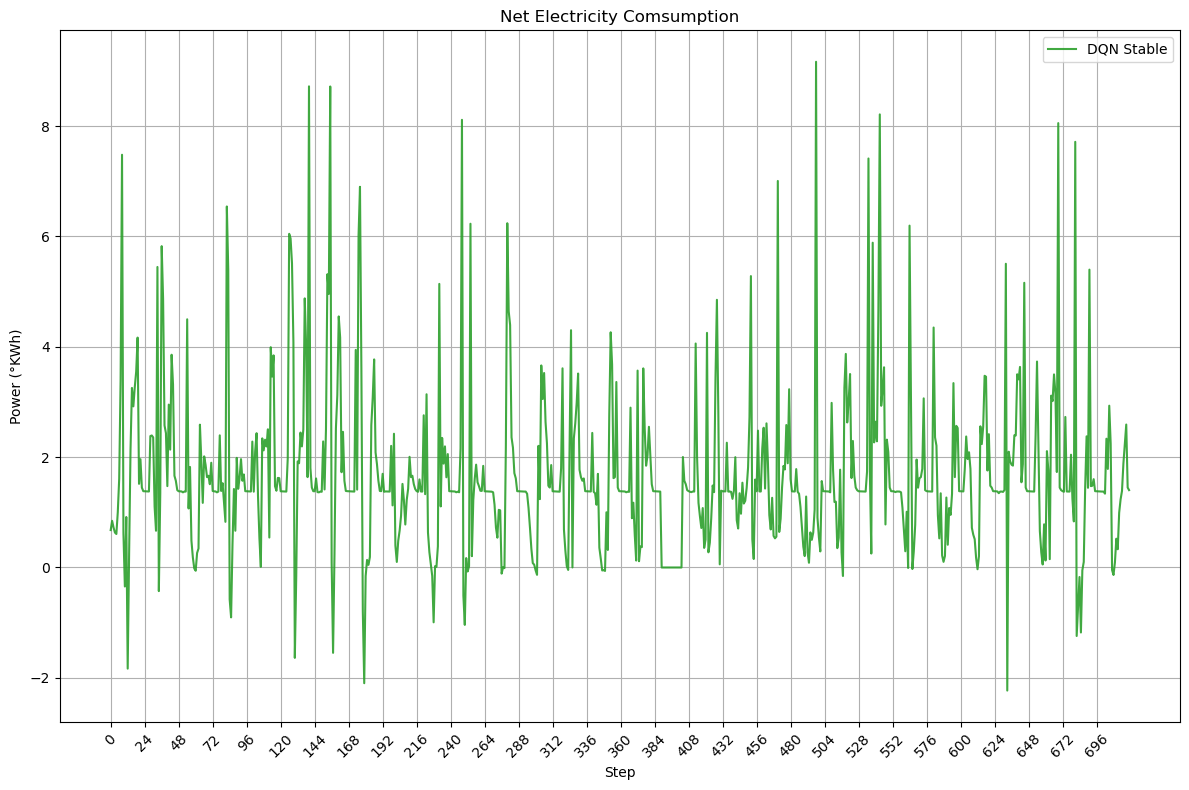

In [4]:
#Calcola il consumo di elettricità totale dell'edificio
energy= env.unwrapped.buildings[num_building].net_electricity_consumption

plt.plot_single_agent(
    energy,
    ylabel='Power (°KWh)',
    title='Net Electricity Comsumption',
    label='DQN Stable',
)


------

## **Comportamento delle temperature**

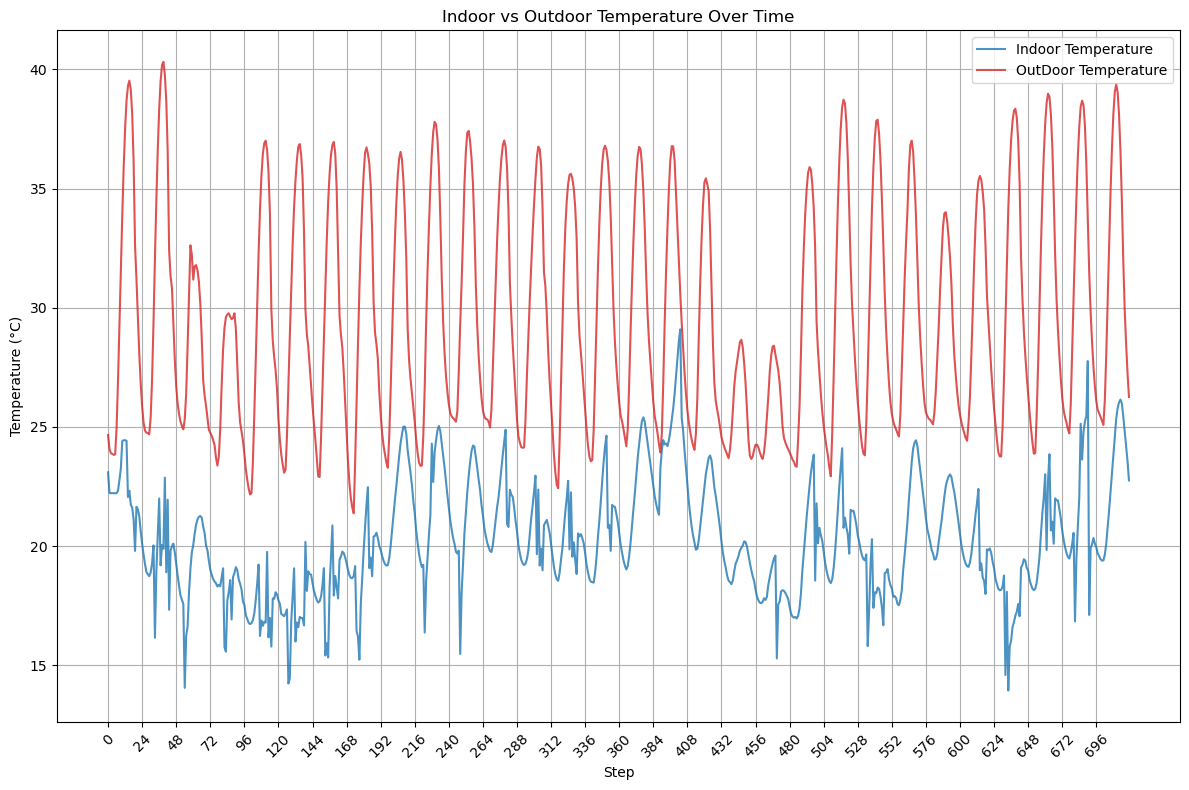

In [5]:
indoor_base_temp = env.unwrapped.buildings[num_building].indoor_dry_bulb_temperature
outdoor_temp = env.unwrapped.buildings[num_building].weather.outdoor_dry_bulb_temperature


plt.plot_comparison_two(
    indoor_base_temp,
    outdoor_temp,
    ylabel='Temperature (°C)',
    title='Indoor vs Outdoor Temperature Over Time',
    label1='Indoor Temperature',
    label2='OutDoor Temperature'
)


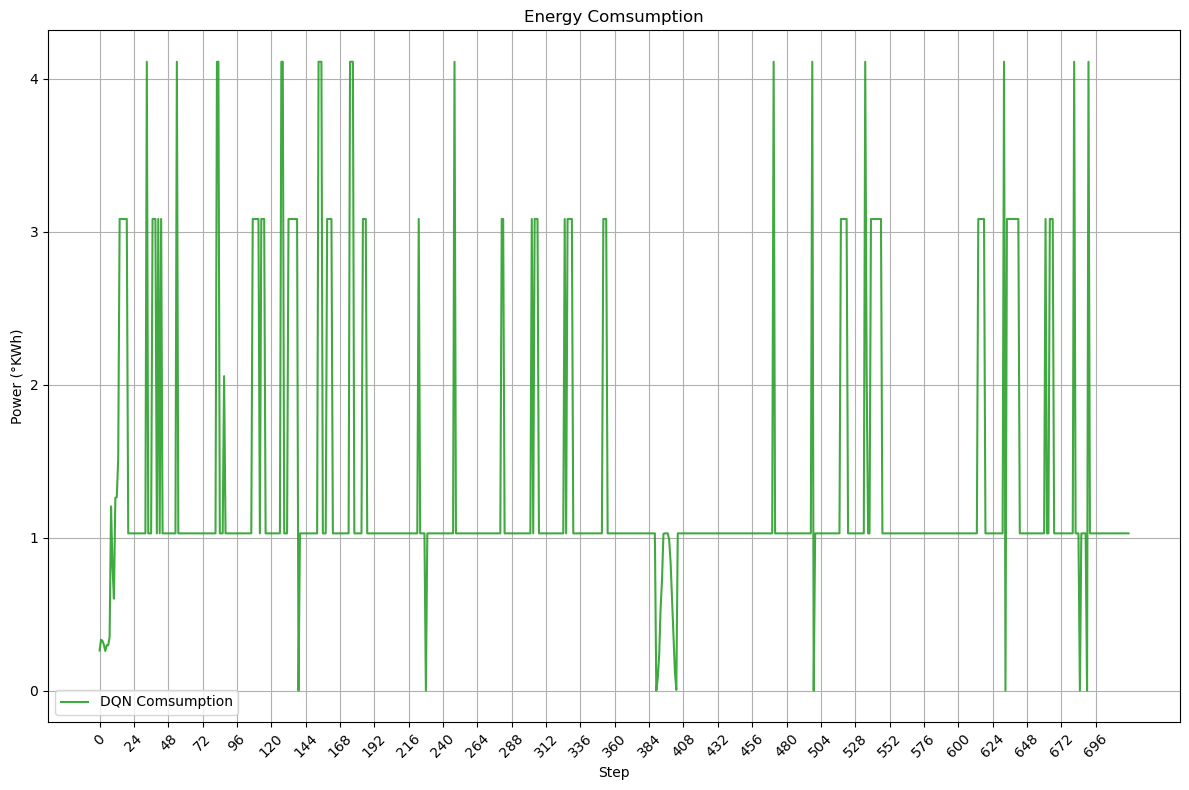

In [6]:
#Questa componente estrae la potenza utilizzata dei dispositivi che servono per regolare la temperatura ambientale

cooler_energy_sac = env.unwrapped.buildings[num_building].cooling_electricity_consumption

plt.plot_single_agent(
    cooler_energy_sac,
    ylabel='Power (°KWh)',
    title='Energy Comsumption',
    label='DQN Comsumption',

)


----

## **Comportamento nell'utilizzo delle batterie**

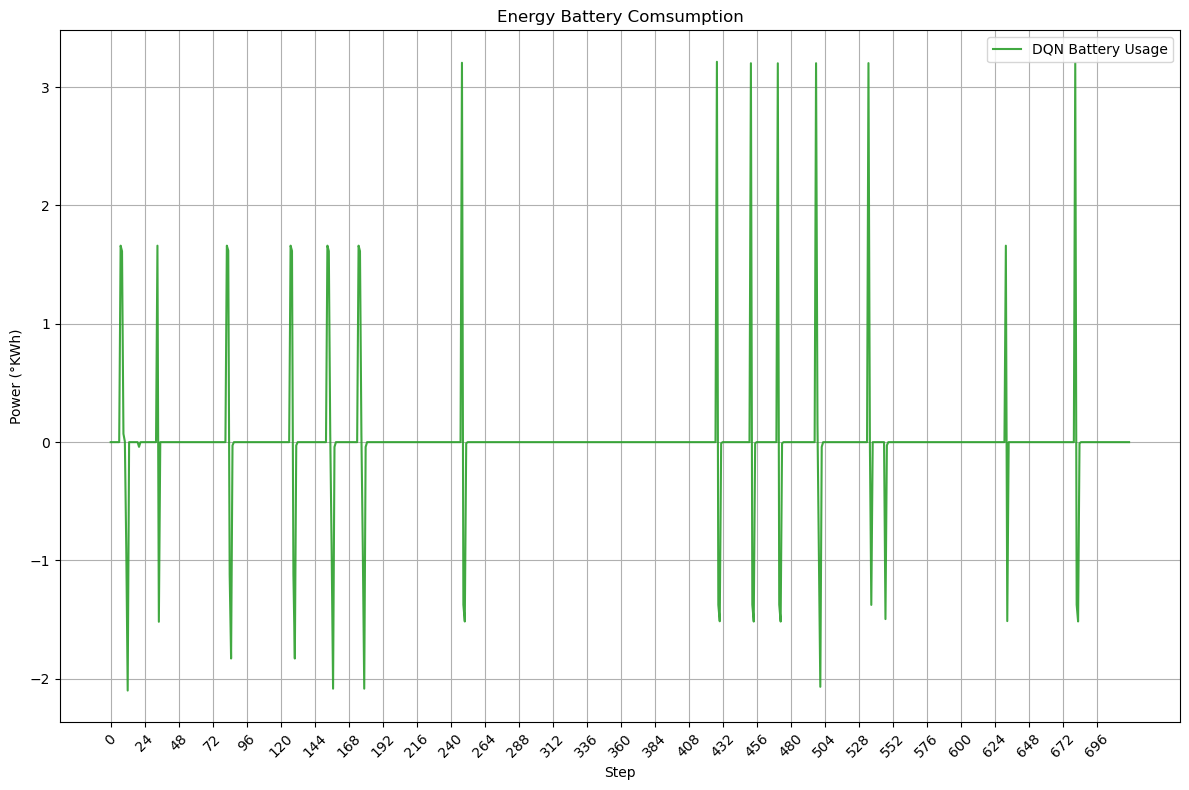

In [7]:
agent_data1 = env.unwrapped.buildings[num_building].electrical_storage_electricity_consumption

plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='Energy Battery Comsumption',
    label='DQN Battery Usage'
)


----

## **Comportamento delle emissioni**

L'emissioni sono strettamente legate ai consumi di energia della rete, perciò le caratteristiche precedenti si propagano anche qua.

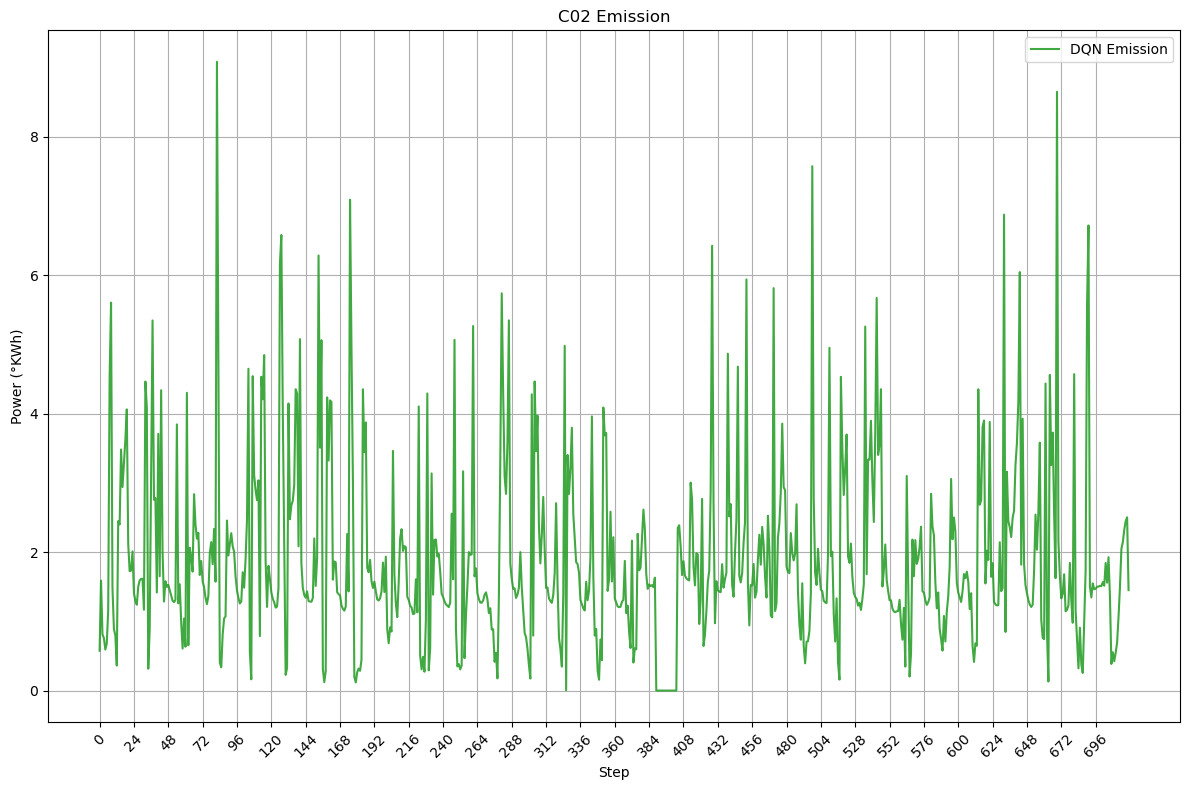

In [8]:
agent_data1 = env.unwrapped.net_electricity_consumption_emission


plt.plot_single_agent(
    agent_data1,
    ylabel='Power (°KWh)',
    title='C02 Emission',
    label='DQN Emission'
)


----

## **Comportamento dei reward e dell'apprendimento**



In [9]:
df = plt.create_episode_table(env.unwrapped.episode_rewards)

display(Markdown(f"### **DQN - Base Version**"))
display(Markdown("----"))
display(df)




### **DQN - Base Version**

----

,Episodio,Reward Min,Reward Max,Reward Somma,Reward Media
0,1,-4663.283203,-0.002338,-874671.500000,-1216.511108
1,2,-4781.590820,-0.002338,-817534.500000,-1137.043823
2,3,-4152.640625,-0.002338,-485260.843750,-674.910767
3,4,-3707.693848,-0.002338,-501808.375000,-697.925415
4,5,-1123.566162,0.000000,-56379.328125,-78.413528
5,6,-1087.621460,-0.002338,-75896.921875,-105.558998
6,7,-1785.470703,-0.002338,-106126.031250,-147.602264
